<a href="https://colab.research.google.com/github/ass77/EradicatorLTSM/blob/master/StockLTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time 

# library for sampling
from scipy.stats import uniform

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# Keras
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:

# Define a callback class
# Resets the states after each epoch (after going through a full time series)
class ModelStateReset(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()
reset=ModelStateReset()

# Different Approach
#class modLSTM(LSTM):
#    def call(self, x, mask=None):
#        if self.stateful: 
#             self.reset_states()
#        return super(modLSTM, self).call(x, mask)

In [4]:
# Function to create an LSTM model, required for KerasClassifier
def create_shallow_LSTM(epochs=1, 
                        LSTM_units=1,
                        num_samples=1, 
                        look_back=1,
                        num_features=None,  
                        dropout_rate=0,
                        recurrent_dropout=0,
                        verbose=0):
    
    model=Sequential()
    
    model.add(LSTM(units=LSTM_units, 
                   batch_input_shape=(num_samples, look_back, num_features), 
                   stateful=True, 
                   recurrent_dropout=recurrent_dropout)) 
    
    model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.he_normal(seed=1)))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    return model

In [10]:
# Imports data
start_sp=datetime.datetime(1980, 1, 1) 
end_sp=datetime.datetime(2020, 9, 10)

yf.pdr_override() 
sp500=pdr.get_data_yahoo('^GSPC', 
                        start_sp,
                        end_sp)
sp500.shape

[*********************100%***********************]  1 of 1 downloaded


(10261, 6)

In [13]:
# Compute the logarithmic returns using the Closing price 
sp500['Log_Ret_1d']=np.log(sp500['Close'] / sp500['Close'].shift(1))

# Compute logarithmic returns using the pandas rolling mean function
sp500['Log_Ret_1w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=5).sum()
sp500['Log_Ret_2w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=10).sum()
sp500['Log_Ret_3w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=15).sum()
sp500['Log_Ret_4w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=20).sum()
sp500['Log_Ret_8w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=40).sum()
sp500['Log_Ret_12w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=60).sum()
sp500['Log_Ret_16w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=80).sum()
sp500['Log_Ret_20w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=100).sum()
sp500['Log_Ret_24w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=120).sum()
sp500['Log_Ret_28w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=140).sum()
sp500['Log_Ret_32w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=160).sum()
sp500['Log_Ret_36w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=180).sum()
sp500['Log_Ret_40w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=200).sum()
sp500['Log_Ret_44w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=220).sum()
sp500['Log_Ret_48w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=240).sum()
sp500['Log_Ret_52w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=260).sum()
sp500['Log_Ret_56w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=280).sum()
sp500['Log_Ret_60w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=300).sum()
sp500['Log_Ret_64w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=320).sum()
sp500['Log_Ret_68w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=340).sum()
sp500['Log_Ret_72w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=360).sum()
sp500['Log_Ret_76w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=380).sum()
sp500['Log_Ret_80w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=400).sum()

# Compute Volatility using the pandas rolling standard deviation function
sp500['Vol_1w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=5).std()*np.sqrt(5)
sp500['Vol_2w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=10).std()*np.sqrt(10)
sp500['Vol_3w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=15).std()*np.sqrt(15)
sp500['Vol_4w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=20).std()*np.sqrt(20)
sp500['Vol_8w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=40).std()*np.sqrt(40)
sp500['Vol_12w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=60).std()*np.sqrt(60)
sp500['Vol_16w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=80).std()*np.sqrt(80)
sp500['Vol_20w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=100).std()*np.sqrt(100)
sp500['Vol_24w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=120).std()*np.sqrt(120)
sp500['Vol_28w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=140).std()*np.sqrt(140)
sp500['Vol_32w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=160).std()*np.sqrt(160)
sp500['Vol_36w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=180).std()*np.sqrt(180)
sp500['Vol_40w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=200).std()*np.sqrt(200)
sp500['Vol_44w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=220).std()*np.sqrt(220)
sp500['Vol_48w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=240).std()*np.sqrt(240)
sp500['Vol_52w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=260).std()*np.sqrt(260)
sp500['Vol_56w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=280).std()*np.sqrt(280)
sp500['Vol_60w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=300).std()*np.sqrt(300)
sp500['Vol_64w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=320).std()*np.sqrt(320)
sp500['Vol_68w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=340).std()*np.sqrt(340)
sp500['Vol_72w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=360).std()*np.sqrt(360)
sp500['Vol_76w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=380).std()*np.sqrt(380)
sp500['Vol_80w']=pd.Series(sp500['Log_Ret_1d']).rolling(window=400).std()*np.sqrt(400)

# Compute Volumes using the pandas rolling mean function
sp500['Volume_1w']=pd.Series(sp500['Volume']).rolling(window=5).mean()
sp500['Volume_2w']=pd.Series(sp500['Volume']).rolling(window=10).mean()
sp500['Volume_3w']=pd.Series(sp500['Volume']).rolling(window=15).mean()
sp500['Volume_4w']=pd.Series(sp500['Volume']).rolling(window=20).mean()
sp500['Volume_8w']=pd.Series(sp500['Volume']).rolling(window=40).mean()
sp500['Volume_12w']=pd.Series(sp500['Volume']).rolling(window=60).mean()
sp500['Volume_16w']=pd.Series(sp500['Volume']).rolling(window=80).mean()
sp500['Volume_20w']=pd.Series(sp500['Volume']).rolling(window=100).mean()
sp500['Volume_24w']=pd.Series(sp500['Volume']).rolling(window=120).mean()
sp500['Volume_28w']=pd.Series(sp500['Volume']).rolling(window=140).mean()
sp500['Volume_32w']=pd.Series(sp500['Volume']).rolling(window=160).mean()
sp500['Volume_36w']=pd.Series(sp500['Volume']).rolling(window=180).mean()
sp500['Volume_40w']=pd.Series(sp500['Volume']).rolling(window=200).mean()
sp500['Volume_44w']=pd.Series(sp500['Volume']).rolling(window=220).mean()
sp500['Volume_48w']=pd.Series(sp500['Volume']).rolling(window=240).mean()
sp500['Volume_52w']=pd.Series(sp500['Volume']).rolling(window=260).mean()
sp500['Volume_56w']=pd.Series(sp500['Volume']).rolling(window=280).mean()
sp500['Volume_60w']=pd.Series(sp500['Volume']).rolling(window=300).mean()
sp500['Volume_64w']=pd.Series(sp500['Volume']).rolling(window=320).mean()
sp500['Volume_68w']=pd.Series(sp500['Volume']).rolling(window=340).mean()
sp500['Volume_72w']=pd.Series(sp500['Volume']).rolling(window=360).mean()
sp500['Volume_76w']=pd.Series(sp500['Volume']).rolling(window=380).mean()
sp500['Volume_80w']=pd.Series(sp500['Volume']).rolling(window=400).mean()

# Label data: Up (Down) if the the 1 month (≈ 21 trading days) logarithmic return increased (decreased)
sp500['Return_Label']=pd.Series(sp500['Log_Ret_1d']).shift(-21).rolling(window=21).sum()
sp500['Label']=np.where(sp500['Return_Label'] > 0, 1, 0)

# Drop NA´s
sp500=sp500.dropna("index")
sp500=sp500.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', "Return_Label"], axis=1)

In [14]:
sp500.head()

,Log_Ret_1d,Log_Ret_1w,Log_Ret_2w,Log_Ret_3w,Log_Ret_4w,Log_Ret_8w,Log_Ret_12w,Log_Ret_16w,Log_Ret_20w,Log_Ret_24w,Log_Ret_28w,Log_Ret_32w,Log_Ret_36w,Log_Ret_40w,Log_Ret_44w,Log_Ret_48w,Log_Ret_52w,Log_Ret_56w,Log_Ret_60w,Log_Ret_64w,Log_Ret_68w,Log_Ret_72w,Log_Ret_76w,Log_Ret_80w,Vol_1w,Vol_2w,Vol_3w,Vol_4w,Vol_8w,Vol_12w,Vol_16w,Vol_20w,Vol_24w,Vol_28w,Vol_32w,Vol_36w,Vol_40w,Vol_44w,Vol_48w,Vol_52w,Vol_56w,Vol_60w,Vol_64w,Vol_68w,Vol_72w,Vol_76w,Vol_80w,Volume_1w,Volume_2w,Volume_3w,Volume_4w,Volume_8w,Volume_12w,Volume_16w,Volume_20w,Volume_24w,Volume_28w,Volume_32w,Volume_36w,Volume_40w,Volume_44w,Volume_48w,Volume_52w,Volume_56w,Volume_60w,Volume_64w,Volume_68w,Volume_72w,Volume_76w,Volume_80w,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-08-03,-0.003367,0.004455,0.013580,0.006459,0.024124,-0.013247,-0.009079,-0.028931,0.004070,0.009549,-0.021307,0.009626,-0.045031,-0.024379,0.012416,0.062293,0.065643,0.130558,0.165119,0.215737,0.284010,0.149601,0.124550,0.210048,0.012918,0.021471,0.027558,0.028869,0.043299,0.052705,0.060915,0.075096,0.082002,0.090800,0.099983,0.112664,0.124961,0.135000,0.141349,0.145846,0.151190,0.155371,0.158784,0.169084,0.181041,0.186131,0.189665,40092000.0,41552000.0,4.211533e+07,42742500.0,45691750.0,4.620900e+07,47895375.0,49148200.0,4.840417e+07,4.733421e+07,47451062.5,4.816483e+07,48047600.0,4.814832e+07,4.799646e+07,4.790835e+07,4.768893e+07,4.715470e+07,46389093.75,4.562300e+07,4.540144e+07,4.560037e+07,45949675.0,0
1981-08-04,0.005350,0.015673,0.021887,0.011732,0.022667,-0.008048,-0.003652,-0.026257,-0.015206,0.022667,-0.017306,0.013276,-0.044505,-0.007897,0.021420,0.058145,0.073123,0.130422,0.163443,0.216533,0.264623,0.143359,0.138969,0.220517,0.010157,0.021222,0.027987,0.028607,0.043669,0.052992,0.061109,0.071088,0.081785,0.090954,0.100110,0.112690,0.124588,0.135052,0.141137,0.145915,0.151186,0.155310,0.158806,0.167439,0.180762,0.185959,0.189642,40352000.0,40770000.0,4.173067e+07,42037500.0,45638750.0,4.616900e+07,47644625.0,48996400.0,4.841825e+07,4.732043e+07,47449562.5,4.798611e+07,47917650.0,4.803955e+07,4.798354e+07,4.788362e+07,4.769511e+07,4.715020e+07,46416781.25,4.560165e+07,4.540325e+07,4.553079e+07,45922125.0,0
1981-08-05,0.011294,0.026813,0.042655,0.018563,0.033338,0.005290,0.022564,-0.013774,-0.003311,0.039905,-0.011615,0.015726,-0.037576,0.008706,0.026116,0.055878,0.085567,0.128087,0.168830,0.225747,0.262010,0.164912,0.141890,0.219532,0.012011,0.018533,0.029729,0.030344,0.045105,0.051990,0.062196,0.072002,0.082297,0.091492,0.100356,0.113187,0.124988,0.135360,0.140941,0.146323,0.150999,0.155590,0.159155,0.167254,0.180773,0.186108,0.189583,43688000.0,41449000.0,4.208667e+07,42452000.0,45881000.0,4.644650e+07,47596625.0,48856400.0,4.858150e+07,4.742507e+07,47528687.5,4.800850e+07,47969500.0,4.804186e+07,4.799821e+07,4.792927e+07,4.772293e+07,4.720257e+07,46499125.00,4.565591e+07,4.544658e+07,4.555100e+07,45960025.0,0
1981-08-06,-0.000226,0.020027,0.040307,0.017492,0.025503,0.002415,0.014581,-0.003838,-0.015263,0.043609,-0.015931,-0.001883,-0.051859,0.000226,0.017032,0.051198,0.093668,0.132412,0.184707,0.221467,0.260903,0.162200,0.148200,0.216587,0.013039,0.018978,0.029763,0.029735,0.045032,0.051448,0.061368,0.071016,0.082187,0.091395,0.098837,0.112274,0.124715,0.135076,0.140878,0.146066,0.150917,0.154691,0.159122,0.167257,0.180763,0.185980,0.189572,45790000.0,42477000.0,4.295733e+07,42780000.0,45852750.0,4.664033e+07,47624250.0,48877700.0,4.873742e+07,4.748800e+07,47536625.0,4.790678e+07,48025300.0,4.803700e+07,4.797262e+07,4.799012e+07,4.774779e+07,4.723613e+07,46565437.50,4.571426e+07,4.546814e+07,4.557468e+07,45978950.0,0
1981-08-07,-0.006732,0.006320,0.025289,0.007543,0.018230,-0.015066,0.009150,-0.007034,-0.016336,0.030361,-0.019691,-0.009443,-0.053999,-0.000683,0.017766,0.051313,0.081568,0.127316,0.169216,0.222574,0.249289,0.170206,0.138935,0.190017,0.016004,0.021065,0.030678,0.030795,0.044161,0.051899,0.061635,0.071108,0.082254,0.09

In [15]:
# Show rows and columns
print("Rows, Columns:");print(sp500.shape);print("\n")

# Describe DataFrame columns
print("Columns:");print(sp500.columns);print("\n")

# Show info on DataFrame
print("Info:");print(sp500.info()); print("\n")

# Count Non-NA values
print("Non-NA:");print(sp500.count()); print("\n")

# Show head
print("Head");print(sp500.head()); print("\n")

# Show tail
print("Tail");print(sp500.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(sp500.describe());print("\n")

Rows, Columns:
(9840, 71)


Columns:
Index(['Log_Ret_1d', 'Log_Ret_1w', 'Log_Ret_2w', 'Log_Ret_3w', 'Log_Ret_4w',
       'Log_Ret_8w', 'Log_Ret_12w', 'Log_Ret_16w', 'Log_Ret_20w',
       'Log_Ret_24w', 'Log_Ret_28w', 'Log_Ret_32w', 'Log_Ret_36w',
       'Log_Ret_40w', 'Log_Ret_44w', 'Log_Ret_48w', 'Log_Ret_52w',
       'Log_Ret_56w', 'Log_Ret_60w', 'Log_Ret_64w', 'Log_Ret_68w',
       'Log_Ret_72w', 'Log_Ret_76w', 'Log_Ret_80w', 'Vol_1w', 'Vol_2w',
       'Vol_3w', 'Vol_4w', 'Vol_8w', 'Vol_12w', 'Vol_16w', 'Vol_20w',
       'Vol_24w', 'Vol_28w', 'Vol_32w', 'Vol_36w', 'Vol_40w', 'Vol_44w',
       'Vol_48w', 'Vol_52w', 'Vol_56w', 'Vol_60w', 'Vol_64w', 'Vol_68w',
       'Vol_72w', 'Vol_76w', 'Vol_80w', 'Volume_1w', 'Volume_2w', 'Volume_3w',
       'Volume_4w', 'Volume_8w', 'Volume_12w', 'Volume_16w', 'Volume_20w',
       'Volume_24w', 'Volume_28w', 'Volume_32w', 'Volume_36w', 'Volume_40w',
       'Volume_44w', 'Volume_48w', 'Volume_52w', 'Volume_56w', 'Volume_60w',
       'Volume_64w', 'V

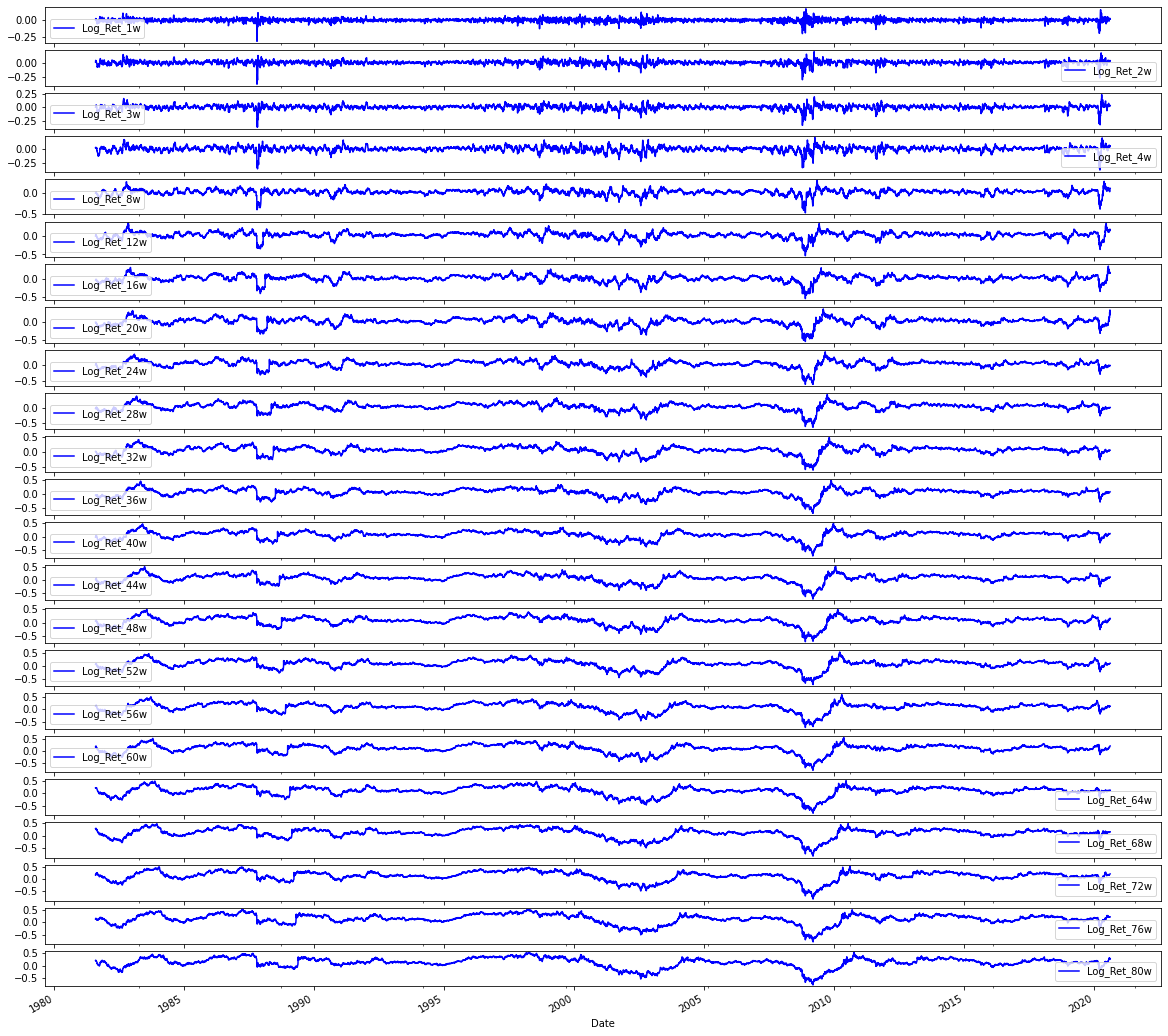

In [19]:
# Plot the logarithmic returns
sp500.iloc[:,1:24].plot(subplots=True, color='blue', figsize=(20, 20));

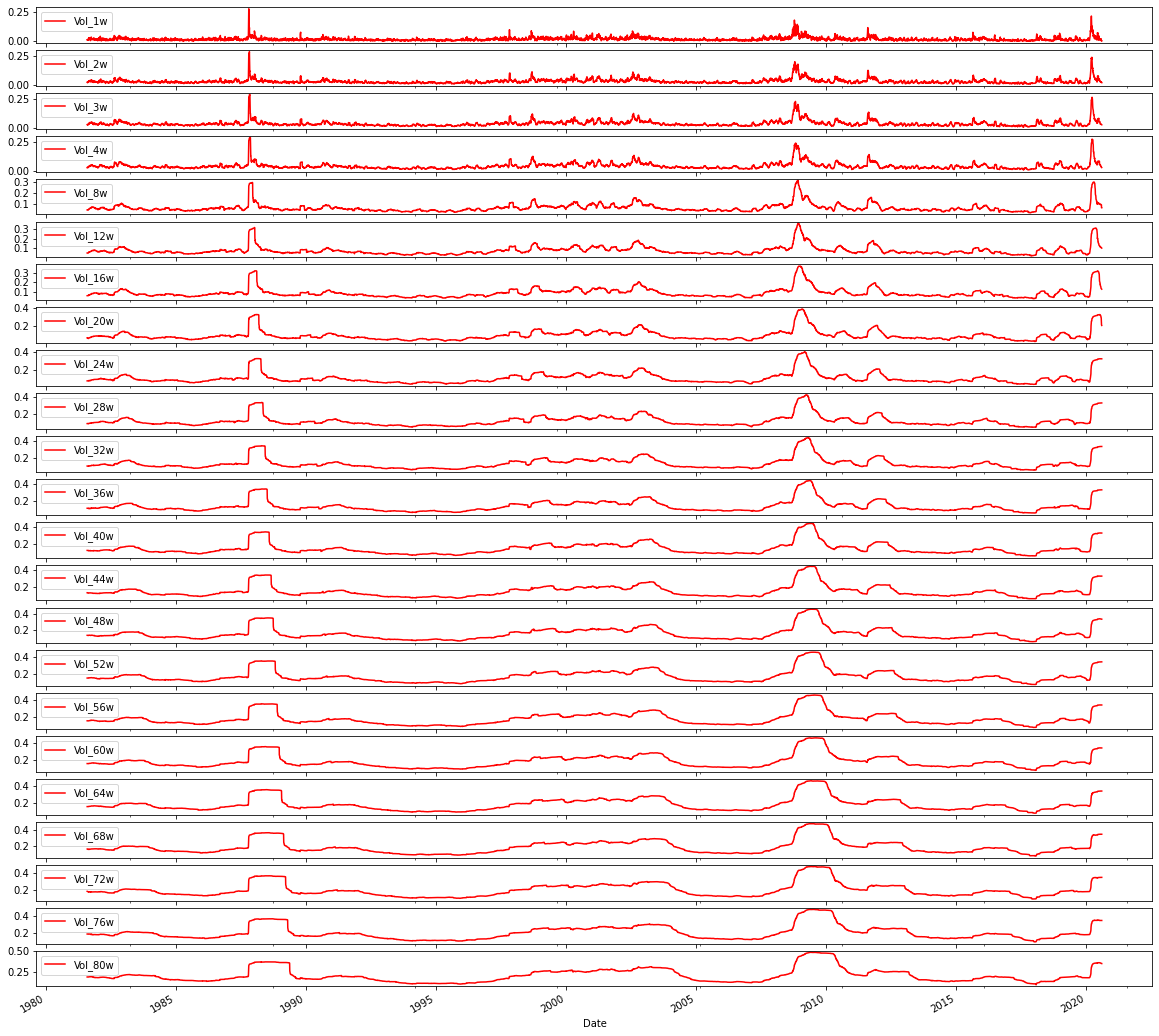

In [18]:
# Plot the Volatilities
sp500.iloc[:,24:47].plot(subplots=True, color='red',figsize=(20, 20));

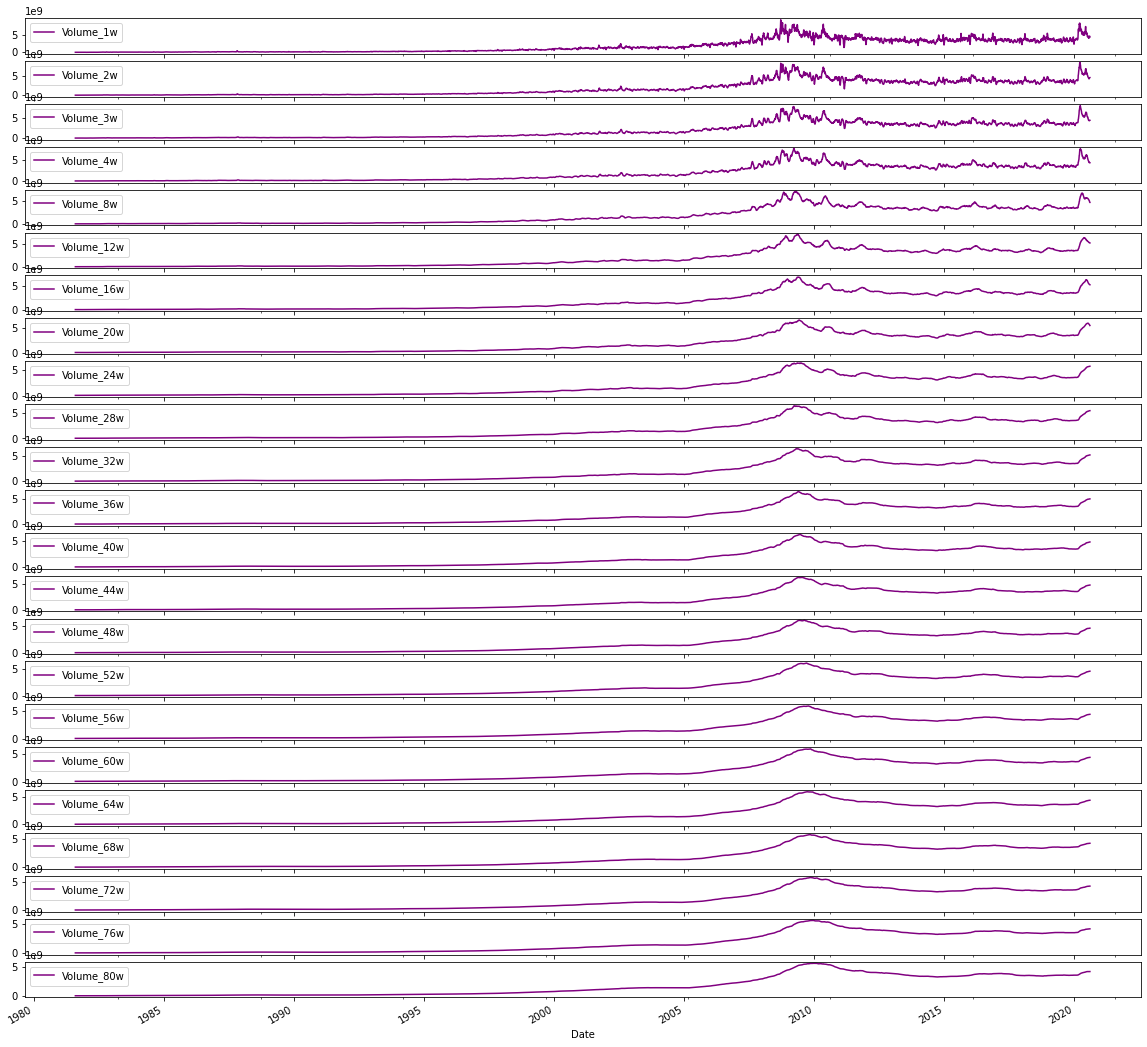

In [22]:
# Plot the Volumes
sp500.iloc[:,47:70].plot(subplots=True, color='purple', figsize=(20, 20));

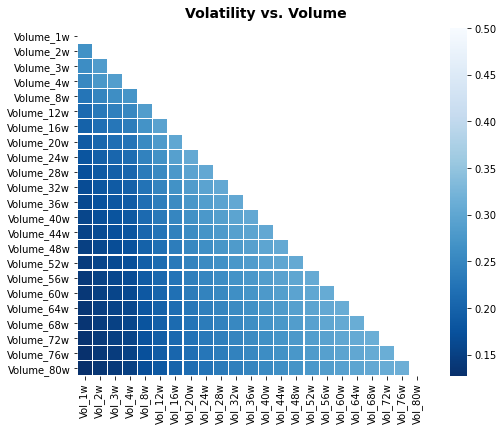

In [26]:
# Plot correlation matrix

focus_cols=sp500.iloc[:,24:47].columns 

corr=sp500.iloc[:,24:70].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Volume', fontsize=14, fontweight='bold')

plt.savefig('heat1.eps', dpi=200, format='eps');

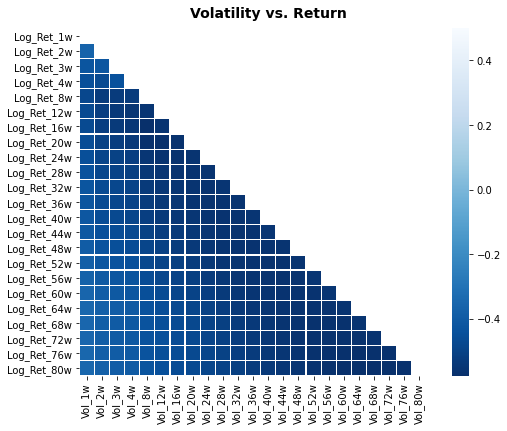

In [27]:
# Plot correlation matrix

focus_cols=sp500.iloc[:,24:47].columns 

corr=sp500.iloc[:,1:47].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volatility vs. Return', fontsize=14, fontweight='bold')

plt.savefig('heat2.eps', dpi=200, format='eps')

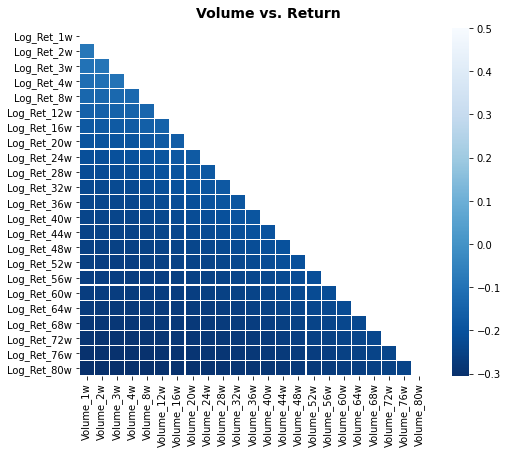

In [28]:
# Plot correlation matrix

focus_cols=sp500.iloc[:,47:70].columns 

corr=sp500.iloc[:, np.r_[1:24, 47:70]].corr().filter(focus_cols).drop(focus_cols)

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(9,6))

heat=sns.heatmap(corr, 
                   ax=ax, 
                   mask=mask, 
                   vmax=.5, 
                   square=True, 
                   linewidths=.2, 
                   cmap="Blues_r")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Volume vs. Return', fontsize=14, fontweight='bold')

plt.savefig('heat3.eps', dpi=200, format='eps');

In [29]:
# Model Set 1: Volatility

# Baseline
X_train_1, X_test_1, y_train_1, y_test_1=train_test_split(sp500.iloc[:,24:47], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_1_lstm=X_train_1.values.reshape(X_train_1.shape[0], 1, X_train_1.shape[1])
X_test_1_lstm=X_test_1.values.reshape(X_test_1.shape[0], 1, X_test_1.shape[1])

# Model Set 2: Return
X_train_2, X_test_2, y_train_2, y_test_2=train_test_split(sp500.iloc[:,1:24], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_2_lstm=X_train_2.values.reshape(X_train_2.shape[0], 1, X_train_2.shape[1])
X_test_2_lstm=X_test_2.values.reshape(X_test_2.shape[0], 1, X_test_2.shape[1])

# Model Set 3: Volume
X_train_3, X_test_3, y_train_3, y_test_3=train_test_split(sp500.iloc[:,47:70], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_3_lstm=X_train_3.values.reshape(X_train_3.shape[0], 1, X_train_3.shape[1])
X_test_3_lstm=X_test_3.values.reshape(X_test_3.shape[0], 1, X_test_3.shape[1])

# Model Set 4: Volatility and Return
X_train_4, X_test_4, y_train_4, y_test_4=train_test_split(sp500.iloc[:,1:47], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_4_lstm=X_train_4.values.reshape(X_train_4.shape[0], 1, X_train_4.shape[1])
X_test_4_lstm=X_test_4.values.reshape(X_test_4.shape[0], 1, X_test_4.shape[1])

# Model Set 5: Volatility and Volume
X_train_5, X_test_5, y_train_5, y_test_5=train_test_split(sp500.iloc[:,24:70], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_5_lstm=X_train_5.values.reshape(X_train_5.shape[0], 1, X_train_5.shape[1])
X_test_5_lstm=X_test_5.values.reshape(X_test_5.shape[0], 1, X_test_5.shape[1])

# Model Set 6: Return and Volume
X_train_6, X_test_6, y_train_6, y_test_6=train_test_split(pd.concat([sp500.iloc[:,1:24], sp500.iloc[:,47:70]], axis=1), sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_6_lstm=X_train_6.values.reshape(X_train_6.shape[0], 1, X_train_6.shape[1])
X_test_6_lstm=X_test_6.values.reshape(X_test_6.shape[0], 1, X_test_6.shape[1])

# Model Set 7: Volatility, Return and Volume
X_train_7, X_test_7, y_train_7, y_test_7=train_test_split(sp500.iloc[:,1:70], sp500.iloc[:,70], test_size=0.1 ,shuffle=False, stratify=None)
# LSTM 
# Input arrays should be shaped as (samples or batch, time_steps or look_back, num_features):
X_train_7_lstm=X_train_7.values.reshape(X_train_7.shape[0], 1, X_train_7.shape[1])
X_test_7_lstm=X_test_7.values.reshape(X_test_7.shape[0], 1, X_test_7.shape[1])

In [30]:
print("train set increase bias = "+ str(np.mean(y_train_7==1))+"%")

print("test set increase bias = " + str(np.mean(y_test_7==1))+"%")

train set increase bias = 0.6210478771454381%
test set increase bias = 0.7184959349593496%


In [31]:

# Time Series Split 
dev_size=0.1 
n_splits=int((1//dev_size)-1)   # using // for integer division
tscv=TimeSeriesSplit(n_splits=n_splits)

In [32]:
# Standardized Data
steps_b=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), 
           ('logistic', linear_model.SGDClassifier(loss="log", shuffle=False, early_stopping=False, tol=1e-3, random_state=1))]

#Normalized Data
#steps_b=[('scaler', MinMaxScaler(feature_range=(0, 1), copy=True)), 
#         ('logistic', linear_model.SGDClassifier(loss="log", shuffle=False, early_stopping=False, tol=1e-3, random_state=1))]

pipeline_b=Pipeline(steps_b) # Using a pipeline we glue together the Scaler & the Classifier
# This ensure that during cross validation the Scaler is fitted to only the training folds

# Penalties
penalty_b=['l1', 'l2', 'elasticnet']

# Evaluation Metric
scoring_b={'AUC': 'roc_auc', 'accuracy': make_scorer(accuracy_score)} #multiple evaluation metrics
metric_b='accuracy' #scorer is used to find the best parameters for refitting the estimator at the end

In [33]:
# Batch_input_shape=[1, 1, Z]  -> (batch size, time steps, number of features) 
# Data set inputs(trainX)=[X, 1, Z]  -> (samples, time steps, number of features)  

# number of samples
num_samples=1 
# time_steps
look_back=1


# Evaluation Metric
scoring_lstm='accuracy'

Loss function: log
accuracy of the best model:  0.5010162601626016


Best hyperparameters:
Number of iterations: 8
Penalty: l2
Alpha: 0.0014
l1_ratio: 0
Total number of features: 23
Number of selected features: 23


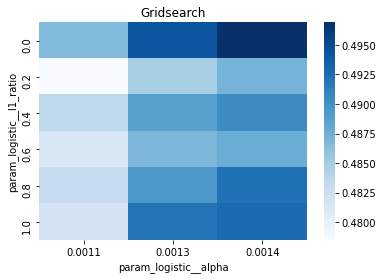

In [34]:
# Model specific Parameter 

# Number of iterations
iterations_1_b=[8] 


# Grid Search

# Regularization  
alpha_g_1_b=[0.0011, 0.0013, 0.0014] #0.0011, 0.0012, 0.0013
l1_ratio_g_1_b=[0, 0.2, 0.4, 0.6, 0.8, 1] 

# Create hyperparameter options
hyperparameters_g_1_b={'logistic__alpha':alpha_g_1_b, 
                       'logistic__l1_ratio':l1_ratio_g_1_b, 
                       'logistic__penalty':penalty_b,  
                       'logistic__max_iter':iterations_1_b}

# Create grid search 
search_g_1_b=GridSearchCV(estimator=pipeline_b, 
                            param_grid=hyperparameters_g_1_b, 
                            cv=tscv, 
                            verbose=0, 
                            n_jobs=-1, 
                            scoring=scoring_b, 
                            refit=metric_b, 
                            return_train_score=False)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated mean Accuracy score. 
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well 

# Fit grid search
tuned_model_1_b=search_g_1_b.fit(X_train_1, y_train_1)
#search_g_1_b.cv_results_


# Random Search

# Create regularization hyperparameter distribution using uniform distribution
#alpha_r_1_b=uniform(loc=0.00006, scale=0.002) 
#l1_ratio_r_1_b=uniform(loc=0, scale=1) 

# Create hyperparameter options
#hyperparameters_r_1_b={'logistic__alpha':alpha_r_1_b, 'logistic__l1_ratio':l1_ratio_r_1_b, 'logistic__penalty':penalty_b,'logistic__max_iter':iterations_1_b}

# Create randomized search 
#search_r_1_b=RandomizedSearchCV(pipeline_b, 
#                                  hyperparameters_r_1_b, 
#                                  n_iter=10, 
#                                  random_state=1, 
#                                  cv=tscv, 
#                                  verbose=0, 
#                                  n_jobs=-1, 
#                                  scoring=scoring_b, 
#                                  refit=metric_b, 
#                                  return_train_score=True)
# Setting refit='Accuracy', refits an estimator on the whole dataset with the parameter setting that has the best cross-validated Accuracy score.
# For multiple metric evaluation, this needs to be a string denoting the scorer is used to find the best parameters for refitting the estimator at the end
# If return_train_score=True training results of CV will be saved as well  

# Fit randomized search
#tuned_model_1_b=search_r_1_b.fit(X_train_1, y_train_1)



# View Cost function
print('Loss function:', tuned_model_1_b.best_estimator_.get_params()['logistic__loss'])

# View Accuracy 
print(metric_b +' of the best model: ', tuned_model_1_b.best_score_);print("\n")
# best_score_ Mean cross-validated score of the best_estimator

# View best hyperparameters
print("Best hyperparameters:")
print('Number of iterations:', tuned_model_1_b.best_estimator_.get_params()['logistic__max_iter'])
print('Penalty:', tuned_model_1_b.best_estimator_.get_params()['logistic__penalty'])
print('Alpha:', tuned_model_1_b.best_estimator_.get_params()['logistic__alpha'])
print('l1_ratio:', tuned_model_1_b.best_estimator_.get_params()['logistic__l1_ratio'])

# Find the number of nonzero coefficients (selected features)
print("Total number of features:", len(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))
print("Number of selected features:", np.count_nonzero(tuned_model_1_b.best_estimator_.steps[1][1].coef_[0][:]))

# Gridsearch table
plt.title('Gridsearch')
pvt_1_b=pd.pivot_table(pd.DataFrame(tuned_model_1_b.cv_results_), values='mean_test_accuracy', index='param_logistic__l1_ratio', columns='param_logistic__alpha')
ax_1_b=sns.heatmap(pvt_1_b, cmap="Blues")
plt.show()

Accuracy: 0.4573170731707317
Precision: 0.7678018575851393
Recall: 0.3507779349363508


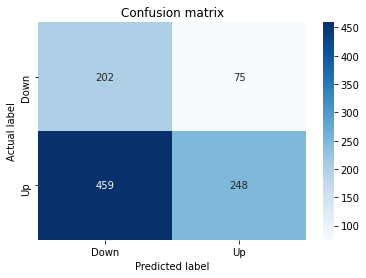

In [35]:
# Make predictions
y_pred_1_b=tuned_model_1_b.predict(X_test_1)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_b)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_b))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_b))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_b))

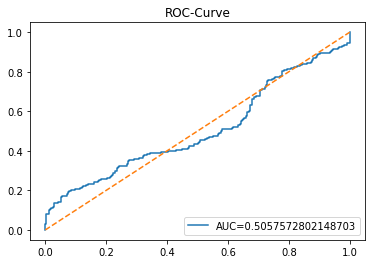

In [36]:
y_proba_1_b=tuned_model_1_b.predict_proba(X_test_1)[:,1]
fpr, tpr, _=metrics.roc_curve(y_test_1,  y_proba_1_b)
auc=metrics.roc_auc_score(y_test_1, y_proba_1_b)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

In [37]:
start=time.time()

# number of epochs
epochs=1
# number of units 
LSTM_units_1_lstm=195
# numer of features
num_features_1_lstm=X_train_1.shape[1]
# Regularization
dropout_rate=0.1
recurrent_dropout=0.1 # 0.21
# print
verbose=0

#hyperparameter
batch_size=[1] 

# hyperparameter
hyperparameter_1_lstm={'batch_size':batch_size}


# create Classifier
clf_1_lstm=KerasClassifier(build_fn=create_shallow_LSTM, 
                          epochs=epochs, 
                          LSTM_units=LSTM_units_1_lstm, 
                          num_samples=num_samples, 
                          look_back=look_back, 
                          num_features=num_features_1_lstm, 
                          dropout_rate=dropout_rate,
                          recurrent_dropout=recurrent_dropout,
                          verbose=verbose)
# Gridsearch
search_1_lstm=GridSearchCV(estimator=clf_1_lstm, 
                          param_grid=hyperparameter_1_lstm,  
                          n_jobs=-1,  
                          cv=tscv, 
                          scoring=scoring_lstm, # accuracy
                          refit=True, 
                          return_train_score=False)

# Fit model
tuned_model_1_lstm=search_1_lstm.fit(X_train_1_lstm, y_train_1, shuffle=False, callbacks=[reset])



print("\n")

# View Accuracy 
print(scoring_lstm +' of the best model: ', tuned_model_1_lstm.best_score_)
# best_score_ Mean cross-validated score of the best_estimator

print("\n")

# View best hyperparameters
print("Best hyperparameters:")
print('epochs:', tuned_model_1_lstm.best_estimator_.get_params()['epochs'])
print('batch_size:', tuned_model_1_lstm.best_estimator_.get_params()['batch_size'])
print('dropout_rate:', tuned_model_1_lstm.best_estimator_.get_params()['dropout_rate'])
print('recurrent_dropout:', tuned_model_1_lstm.best_estimator_.get_params()['recurrent_dropout'])

end=time.time()
print("\n")
print("Running Time:", end - start)



accuracy of the best model:  0.5735518292682926


Best hyperparameters:
epochs: 1
batch_size: 1
dropout_rate: 0.1
recurrent_dropout: 0.1


Running Time: 198.95055222511292


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy: 0.7184959349593496
Precision: 0.7184959349593496
Recall: 1.0


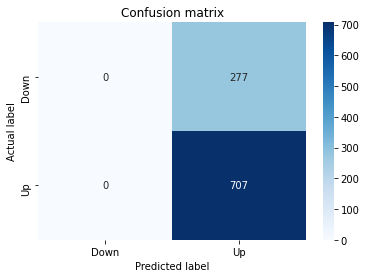

In [38]:
# Make predictions
y_pred_1_lstm=tuned_model_1_lstm.predict(X_test_1_lstm)

# create confustion matrix
fig, ax=plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test_1, y_pred_1_lstm)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']); ax.yaxis.set_ticklabels(['Down', 'Up'])

print("Accuracy:",metrics.accuracy_score(y_test_1, y_pred_1_lstm))
print("Precision:",metrics.precision_score(y_test_1, y_pred_1_lstm))
print("Recall:",metrics.recall_score(y_test_1, y_pred_1_lstm))

Instructions for updating:
Please use `model.predict()` instead.


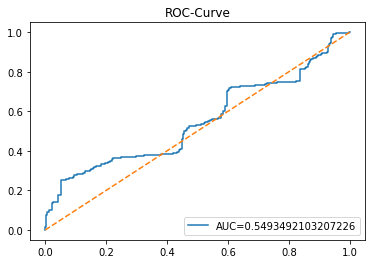

In [39]:
y_proba_1_lstm=tuned_model_1_lstm.predict_proba(X_test_1_lstm)[:, 1]
fpr, tpr, _=metrics.roc_curve(y_test_1,  y_proba_1_lstm)
auc=metrics.roc_auc_score(y_test_1, y_proba_1_lstm)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()